# Install packages

In [ ]:
! pip install qdrant-client transformers datasets torch sentence-transformers matplotlib

## Load dataset

Use HuggingFace's [`datasets`](https://huggingface.co/docs/datasets/index) library to download the dataset and load it into your session. This library is quick, efficient and will allow you to manipulate unstructured data in other ways.

The `load_dataset` function directly downloads the dataset from the [HuggingFace Data Hub](https://huggingface.co/datasets) to your local machine.

In [1]:
from datasets import load_dataset

/mnt/d/devel/github/searchbot/qdrant/qdrant_linux_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("ag_news", split="train")
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

## Examine the Dataset

In [3]:
from random import choice

for i in range(5):
    random_sample = choice(range(len(dataset)))
    print(f"Sample {i+1}")
    print("=" * 70)
    print(dataset[random_sample]['text'])
    print()

Sample 1
'San Andreas' Among Best Games "Grand Theft Auto: San Andreas" is an epic homage to the West Coast gang culture of the early 1990s. Yes, parents, there's way too much violence and profanity here for the kids. For those of us 18 and older, though, it's among the best video games this year.

Sample 2
Four Suicides Linked to Child Porn Probe (AP) AP - The government will press on with a child pornography crackdown despite the suicides of four people being investigated in the operation, an official said Saturday.

Sample 3
Vikings Likely Lose Rosenthal for Year (AP) AP - Minnesota Vikings right tackle Mike Rosenthal is likely out for the season with an injury to his right foot.

Sample 4
A New Player in Desktop Search Copernic, a well-known developer of web search tools, is entering the desktop search marketplace with the release of a new product today. 

Sample 5
Fannie Salaries Rile Hill Data showing that 16 executives received bonuses in 2002 that were larger than their salarie

In [4]:
id2label = {str(i): label for i, label in enumerate(dataset.features["label"].names)}

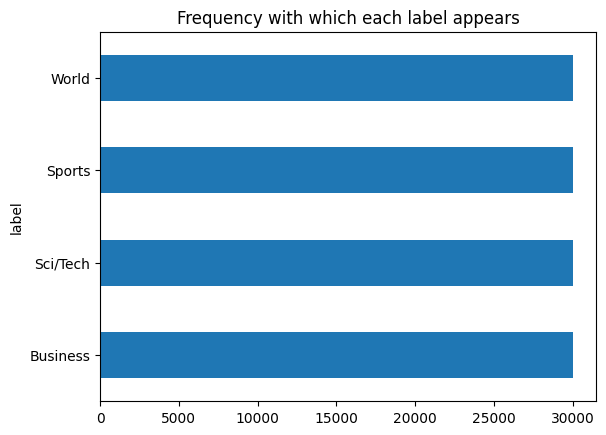

In [5]:
(
    dataset.select_columns('label')
           .to_pandas()
           .astype(str)['label']
           .map(id2label)
           .value_counts()
           .plot(kind="barh", title="Frequency with which each label appears")
);

In [6]:
def get_lenght_of_text(example):
    example['length_of_text'] = len(example['text'])
    return example

dataset = dataset.map(get_lenght_of_text)
dataset[:10]['length_of_text']

[144, 266, 232, 256, 234, 239, 215, 252, 414, 147]

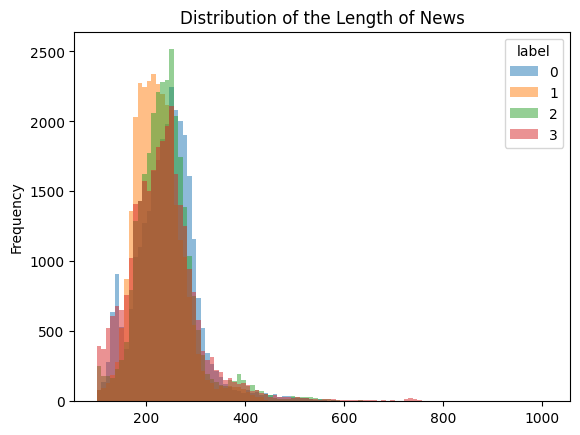

In [7]:
(
    dataset.select_columns(["label", "length_of_text"])
           .to_pandas()
           .pivot(columns='label', values='length_of_text')
           .plot.hist(bins=100, alpha=0.5, title="Distribution of the Length of News")
);

## Tokenizer

If you would like to use a different model to follow along, you can find all of the models available at Hugging Face's model hub

In [8]:
from transformers import AutoModel, AutoTokenizer
import torch

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModel.from_pretrained('gpt2')#.to(device) # switch this for GPU

In [11]:
tokenizer.eos_token
tokenizer.pad_token
tokenizer.pad_token = tokenizer.eos_token


In [12]:
text = "What does a cow use to do math? A cow-culator with blank and black pads."
inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")#.to(device)
inputs

{'input_ids': tensor([[ 2061,   857,   257,  9875,   779,   284,   466, 10688,    30,   317,
          9875,    12,  3129,  1352,   351,  9178,   290,  2042, 21226,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [13]:
toks = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
toks

['What',
 'Ġdoes',
 'Ġa',
 'Ġcow',
 'Ġuse',
 'Ġto',
 'Ġdo',
 'Ġmath',
 '?',
 'ĠA',
 'Ġcow',
 '-',
 'cul',
 'ator',
 'Ġwith',
 'Ġblank',
 'Ġand',
 'Ġblack',
 'Ġpads',
 '.']

In [14]:
tokenizer.convert_tokens_to_string(toks)

'What does a cow use to do math? A cow-culator with blank and black pads.'

In [15]:
with torch.no_grad():
    embs = model(**inputs)

embs.last_hidden_state.size(), embs[0]

(torch.Size([1, 20, 768]),
 tensor([[[-0.1643,  0.0957, -0.2844,  ..., -0.1632, -0.0774, -0.2154],
          [ 0.0472,  0.2181,  0.0754,  ...,  0.0281,  0.2386, -0.0731],
          [-0.1410,  0.1957,  0.5674,  ..., -0.4050,  0.1199, -0.0043],
          ...,
          [ 0.4970,  0.1432, -0.5701,  ...,  0.0789, -0.4908, -0.3930],
          [ 0.1902,  0.0015, -1.3648,  ...,  0.0389,  0.0778, -0.0853],
          [-0.0123, -0.3443, -0.3632,  ...,  0.2537, -0.1566, -0.1679]]]))

### Mean pooling

In [16]:
def mean_pooling(model_output, attention_mask):

    token_embeddings = model_output[0]
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [17]:
embedding = mean_pooling(embs, inputs["attention_mask"])
embedding.shape, embedding[0, :10]

(torch.Size([1, 768]),
 tensor([-0.0525,  0.0117, -0.6072, -0.1473, -0.1523,  0.3656,  2.2516,  0.1550,
         -0.1681,  0.0549]))

In [18]:
def embed_text(examples):
    inputs = tokenizer(
        examples["text"], padding=True, truncation=True, return_tensors="pt"
    )#.to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [20]:
small_set = (
    dataset.shuffle(42) # randomly shuffles the data, 42 is the seed
           .select(range(1000)) # we'll take 1k rows
           .map(embed_text, batched=True, batch_size=128) # and apply our function above to 128 articles at a time
)

Map: 100%|██████████| 1000/1000 [07:27<00:00,  2.23 examples/s]


In [27]:
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding'],
    num_rows: 1000
})

In [28]:
n_rows = range(len(small_set))
small_set = small_set.add_column("idx", n_rows)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx'],
    num_rows: 1000
})

In [29]:
small_set['idx'][-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [30]:
def get_names(label_num):
    return id2label[str(label_num)]

label_names = list(map(get_names, small_set['label']))
small_set = small_set.add_column("label_names", label_names)
small_set

Dataset({
    features: ['text', 'label', 'length_of_text', 'embedding', 'idx', 'label_names'],
    num_rows: 1000
})

In [31]:
dim_size = len(small_set[0]["embedding"]) # we'll need the dimensions of our embeddings
dim_size

768

## Qdrant search

In [32]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import CollectionStatus

In [33]:
client = QdrantClient(host="localhost", port=6333)
client

In [ ]:
my_collection = "news_embeddings"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=dim_size, distance=models.Distance.COSINE)
)

In [35]:
payloads = small_set.select_columns(["label_names", "text"]).to_pandas().to_dict(orient="records")
payloads[:3]

[{'label_names': 'World',
  'text': 'Bangladesh paralysed by strikes Opposition activists have brought many towns and cities in Bangladesh to a halt, the day after 18 people died in explosions at a political rally.'},
 {'label_names': 'Sports',
  'text': 'Desiring Stability Redskins coach Joe Gibbs expects few major personnel changes in the offseason and wants to instill a culture of stability in Washington.'},
 {'label_names': 'World',
  'text': 'Will Putin #39;s Power Play Make Russia Safer? Outwardly, Russia has not changed since the barrage of terrorist attacks that culminated in the school massacre in Beslan on Sept.'}]

In [36]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=small_set["idx"],
        vectors=small_set["embedding"],
        payloads=payloads
    )
)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [37]:
client.scroll(
    collection_name=my_collection,
    limit=10,
    with_payload=False, # change to True to see the payload
    with_vectors=False  # change to True to see the vectors
)

([Record(id=0, payload=None, vector=None, shard_key=None),
  Record(id=1, payload=None, vector=None, shard_key=None),
  Record(id=2, payload=None, vector=None, shard_key=None),
  Record(id=3, payload=None, vector=None, shard_key=None),
  Record(id=4, payload=None, vector=None, shard_key=None),
  Record(id=5, payload=None, vector=None, shard_key=None),
  Record(id=6, payload=None, vector=None, shard_key=None),
  Record(id=7, payload=None, vector=None, shard_key=None),
  Record(id=8, payload=None, vector=None, shard_key=None),
  Record(id=9, payload=None, vector=None, shard_key=None)],
 10)

In [38]:
query1 = small_set[100]['embedding']
small_set[100]['text'], query1[:7]

('Stocks creep higher in New York NEW YORKUS blue-chip stocks ended barely higher yesterday as a spike in oil prices to record closing levels pared earlier gains and renewed concerns about the effect of high energy prices on consumer spending and corporate profits.',
 [0.12031634151935577,
  0.04675324633717537,
  0.11301228404045105,
  0.44551166892051697,
  0.05810481309890747,
  -0.09899602830410004,
  1.7481718063354492])

In [39]:
client.search(
    collection_name=my_collection,
    query_vector=query1,
    limit=3
)

[ScoredPoint(id=100, version=0, score=0.9999999, payload={'label_names': 'Business', 'text': 'Stocks creep higher in New York NEW YORKUS blue-chip stocks ended barely higher yesterday as a spike in oil prices to record closing levels pared earlier gains and renewed concerns about the effect of high energy prices on consumer spending and corporate profits.'}, vector=None, shard_key=None),
 ScoredPoint(id=789, version=0, score=0.9995748, payload={'label_names': 'World', 'text': 'German investor confidence surges BERLIN - German investor confidence posted a surprise jump in December as relief over falling oil prices helped to offset concerns about the impact of a surging euro on growth in Europe #39;s biggest economy.'}, vector=None, shard_key=None),
 ScoredPoint(id=379, version=0, score=0.9994168, payload={'label_names': 'Business', 'text': 'German recovery already running out of steam: research institutes (AFP) AFP - The German economy, which grew strongly in the first half of this year

In [40]:
# Step 1 - Select Random Sample
query2 = {"text": dataset[choice(range(len(dataset)))]['text']}
query2

{'text': 'White House Creates Cabinet-Level Ocean Policy Panel (Reuters) Reuters - The Bush administration created on\\Friday a cabinet-level committee to address rising pollution\\and overfishing in U.S. territorial ocean waters.'}

In [41]:
# Step 2 - Create a Vector
query2 = embed_text(query2)['embedding'][0, :]
query2.shape, query2[:20]

((768,),
 array([-1.6405903e-01,  3.4435403e-01,  9.6796884e-04, -1.3294506e-01,
        -1.7553170e-01, -4.6307757e-01,  6.5672388e+00,  7.9309508e-02,
         1.5689157e-01,  2.4146332e-01,  1.0775393e-01, -2.2428678e-01,
        -4.4264579e-03,  1.8589190e-01, -3.0145481e-01,  4.3851683e-01,
        -3.0271204e-02, -8.1561528e-02, -1.5778922e-01, -4.0176904e-01],
       dtype=float32))

In [42]:
# Step 3 - Search for similar articles. Don't forget to convert the vector to a list.
client.search(
    collection_name=my_collection,
    query_vector=query2.tolist(),
    limit=5
)

[ScoredPoint(id=359, version=0, score=0.9988396, payload={'label_names': 'World', 'text': "Blair Puts Security at Heart of Pre-Election Plans  LONDON (Reuters) - Britain's Tony Blair will spell out this  week his legislative plans for the next session of parliament  -- tantamount to an election manifesto, with the prime minister  expected to go to the polls in May next year."}, vector=None, shard_key=None),
 ScoredPoint(id=19, version=0, score=0.9987976, payload={'label_names': 'Sci/Tech', 'text': 'U.S. Plans Crackdown on Piracy, Counterfeiting  WASHINGTON (Reuters) - The United States is cracking down  on the growing trade in counterfeit and pirated goods that  costs U.S. businesses hundreds of billions of dollar annually,  U.S. government and industry officials said on Monday.'}, vector=None, shard_key=None),
 ScoredPoint(id=228, version=0, score=0.99878126, payload={'label_names': 'Sci/Tech', 'text': 'Ex-U.S. Cyber Security Chief Sees Curb on Phishing  SAN FRANCISCO (Reuters) - A fo

In [43]:
business = models.Filter(
    must=[models.FieldCondition(key="label_names", match=models.MatchValue(value="Business"))]
)

In [44]:
client.search(
    collection_name=my_collection,
    query_vector=query2.tolist(),
    query_filter=business,
    limit=5
)

[ScoredPoint(id=423, version=0, score=0.99873286, payload={'label_names': 'Business', 'text': 'Housing Starts Surge 6.4 Pct. in October (Reuters) Reuters - U.S. housing starts jumped a\\larger-than-expected 6.4 percent in October to the busiest pace\\since December as buyers took advantage of low mortgage rates,\\a government report showed on Wednesday.'}, vector=None, shard_key=None),
 ScoredPoint(id=708, version=0, score=0.9987263, payload={'label_names': 'Business', 'text': 'Oil Surges on Storm, Supply Concerns  NEW YORK (Reuters) - World oil prices surged nearly \\$2 on  Friday on worries the stormy season in the Gulf of Mexico would  continue to hamper energy production and imports, delaying  vital stock building ahead of the coming winter months.'}, vector=None, shard_key=None),
 ScoredPoint(id=96, version=0, score=0.9986123, payload={'label_names': 'Business', 'text': 'Chain Store Sales Mixed in Oct 16 Week  NEW YORK (Reuters) - U.S. chain store sales rose in the  second week of